# 混合正規分布のEMアルゴリズムによるパラメータ推定
混合正規分布に従ってサンプリングされる標本より，分布のパラメータを推定する  
$$ p(x) = \sum_{i} \pi_iN\left(x\ |\mu_i, \sigma^2_i \right) $$

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### 必要な奴らの定義

In [7]:
def makeGaussian(mu, sig):
    """
    正規分布(1次元)の確率密度関数の作成
    mu: 平均
    sig: 分散
    
    return: func(x)
    """
    def gaussian(x):
        y = np.exp(-(x-mu)**2/(2*sig)) / (np.sqrt(2*np.pi*sig))
        return y
    return gaussian

def samplingMixGauss(mu, sig, N):
    """
    混合正規分布に従うサンプリング？
    mu: 平均のリスト
    sig: 分散のリスト
    N: サンプリング数のリスト
    
    return: サンプル
    """
    X = []
    for m,s,n in zip(mu,sig,N):
        X = X + np.random.normal(m,s,n).tolist()
    return np.array(X)

In [8]:
def E_Step(mu,sig,W,sample):
    """
    Eステップ処理
    mu: 平均のリスト
    sig: 分散のリスト
    W: 重みのリスト
    sample: サンプリング集合
    
    return: 負担率
    """
    k = len(mu)
    n = len(sample)
    gm = np.zeros((k, n))
    for i,(m,s,w) in enumerate(zip(mu,sig,W)):
        gm[i,:] = w*(makeGaussian(m,s))(sample)
    return gm/gm.sum(axis=0)

def M_Step(gm,sample):
    """
    Mステップ処理
    gm: 負担率のリスト
    sample: サンプリング集合
    
    return; 平均，分散，重み
    """
    k = len(gm)
    N = len(sample)
    Mu, Sig, W = np.zeros(k), np.zeros(k), np.zeros(k)
    for i, g in enumerate(gm):
        Nk = g.sum()
        Mu[i] = (g*sample).sum() / Nk
        Sig[i] = (g*((sample-Mu[i])**2)).sum() / Nk
        W[i] = Nk / N
    return (Mu, Sig, W)

### 真のパラメータ

In [9]:
W = np.array([0.1, 0.5, 0.4])
Mu = np.array([-6., 1, 5])
Sig = np.array([1, 1, 1.5])

### サンプリング

In [41]:
x_min, x_max, n = -10, 10, 100
s_n = 10000

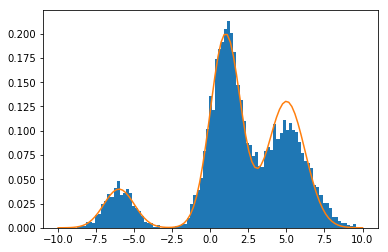

In [42]:
s = samplingMixGauss(Mu,Sig,[int(w*s_n) for w in W])
_=plt.hist(s, bins=np.linspace(x_min, x_max, 100),normed=True)
x = np.linspace(x_min, x_max, n)
y = np.array([w*(makeGaussian(m,s))(x) for w,m,s in zip(W,Mu,Sig)]).sum(axis=0)
plt.plot(x, y)

### モデルのパラメータ

In [43]:
k = 3
#W_model = np.random.uniform(size=k)/k
#Mu_model = np.random.uniform(-5, 5, size=k)
#Sig_model = np.random.uniform(0.1, 2, size=k)
Mu_model = np.array([0, 0, 0])
Sig_model = np.array([1,1,1])
W_model = np.array([1/3,1/3,1/3])

## Eステップ
負担率のプロット

In [44]:
gm = E_Step(Mu_model,Sig_model,W_model,s)

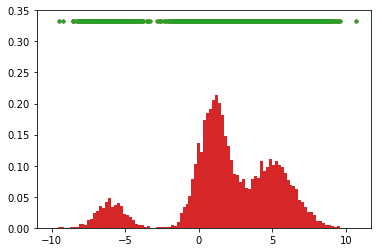

In [45]:
for i in range(k):
    plt.plot(s, gm[i,:], ".")
_=plt.hist(s, bins=np.linspace(x_min, x_max, 100),normed=True)

### Mステップ
推定値モデルをプロット

In [46]:
Mu_model,Sig_model,W_model = M_Step(gm,s)

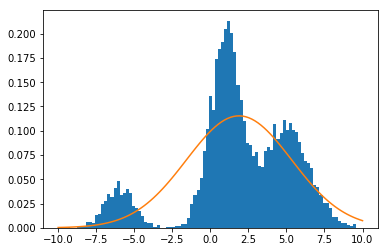

In [47]:
_=plt.hist(s, bins=np.linspace(x_min, x_max, 100),normed=True)
x = np.linspace(x_min, x_max, 100)
y = np.array([w*(makeGaussian(m,s))(x) for w,m,s in zip(W_model,Mu_model,Sig_model)]).sum(axis=0)
plt.plot(x, y)

## Eステップ → Mステップの繰り返し

In [48]:
step = 100

In [49]:
for i in range(step):
    gm = E_Step(Mu_model,Sig_model,W_model,s)
    Mu_model,Sig_model,W_model = M_Step(gm,s)

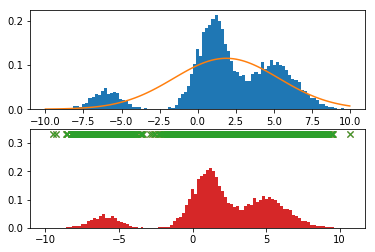

In [50]:
plt.subplot(211)
_=plt.hist(s, bins=np.linspace(x_min, x_max, 100),normed=True)
x = np.linspace(x_min, x_max, n)
y = np.array([w*(makeGaussian(m,s))(x) for w,m,s in zip(W_model,Mu_model,Sig_model)]).sum(axis=0)
plt.plot(x, y)

plt.subplot(212)
for i in range(k):
    plt.plot(s, gm[i,:], "x")
_=plt.hist(s, bins=np.linspace(x_min, x_max, 100),normed=True)

### パラメータの真値

In [29]:
df = pd.DataFrame([(w,m,s) for w,m,s in zip(W,Mu,Sig)], columns=["重み", "平均", "分散"])
df.sort_values(by="重み")

,重み,平均,分散
0,0.1,-6.0,1.0
2,0.4,5.0,1.5
1,0.5,1.0,1.0


### パラメータの推定値

In [30]:
df = pd.DataFrame([(w,m,s) for w,m,s in zip(W_model,Mu_model,Sig_model)], columns=["重み", "平均", "分散"])
df.sort_values(by="重み")

,重み,平均,分散
0,0.100068,-6.035022,0.924082
1,0.402562,4.970114,2.430036
2,0.497369,1.025079,1.008278
